# 06 - Theoretical Analysis

This notebook analyzes **why different unlearning methods succeed or fail** for VAEs on scRNA-seq data:

1. ELBO decomposition: What happens to reconstruction and KL after unlearning?
2. Posterior collapse: Does Fisher scrubbing cause encoder collapse?
3. Method comparison: Why does extra-gradient succeed where Fisher fails?
4. Biological confounding: Understanding the baseline memorization

**Key findings from notebooks 04-05:**
- **Extra-gradient (λ=10):** SUCCESS - 75% achieve retrain-equivalent privacy (AUC ~0.46)
- **Fisher unlearning:** FAILURE - fine-tuning re-learns the signal (AUC ~0.79)
- **Frozen critics:** FAILURE - adversarial blind spot problem (AUC ~0.99)

In [1]:
import sys
sys.path.insert(0, '../src')

import numpy as np
import torch
import torch.nn as nn
import scanpy as sc
import matplotlib.pyplot as plt
import json
from pathlib import Path

from utils import set_global_seed, GLOBAL_SEED, DEVICE
from vae import VAE

set_global_seed(GLOBAL_SEED)

DATA_DIR = Path('../data')
P1_DIR = Path('../outputs/p1')
P2_DIR = Path('../outputs/p2')
OUTPUT_DIR = P2_DIR / 'theory'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"Device: {DEVICE}")

Device: cpu


## Load Data and Models

We compare four models:
- **Baseline**: Original VAE trained on all data
- **Fisher-unlearned**: After scrubbing + finetuning (from notebook 05) - FAILS
- **Extra-gradient**: Adversarial unlearning with co-training (from notebook 04) - SUCCEEDS
- **Retrain**: Model trained from scratch without forget set (gold standard)

In [2]:
# Load data
adata = sc.read_h5ad(DATA_DIR / 'adata_processed.h5ad')
print(f"Loaded data: {adata.shape}")

# Load splits
with open(P1_DIR / 'split_structured.json') as f:
    split = json.load(f)

forget_idx = np.array(split['forget_indices'])
retain_idx = np.array(split['retain_indices'])
print(f"Forget: {len(forget_idx)}, Retain: {len(retain_idx)}")

# Helper to load VAE
def load_vae(path):
    ckpt = torch.load(path, map_location=DEVICE)
    config = ckpt['config']
    model = VAE(
        input_dim=config['input_dim'],
        latent_dim=config['latent_dim'],
        hidden_dims=config['hidden_dims'],
        likelihood=config['likelihood'],
        dropout=config.get('dropout', 0.1),
        use_layer_norm=config.get('use_layer_norm', True)
    ).to(DEVICE)
    model.load_state_dict(ckpt['model_state_dict'])
    model.eval()
    return model, config

# Load models
baseline, config = load_vae(P1_DIR / 'baseline' / 'best_model.pt')
fisher_model, _ = load_vae(P2_DIR / 'fisher_unlearn' / 'fisher_unlearned_model.pt')
retrain_model, _ = load_vae(P1_DIR / 'retrain_structured' / 'best_model.pt')

# Load extra-gradient model (the successful one!)
EXTRAGRADIENT_PATH = P2_DIR / 'adversarial_sweep' / 'extragradient_lambda10_model.pt'
if EXTRAGRADIENT_PATH.exists():
    extragradient_model, _ = load_vae(EXTRAGRADIENT_PATH)
    print("Loaded extra-gradient model (SUCCESS)")
else:
    print(f"WARNING: Extra-gradient model not found at {EXTRAGRADIENT_PATH}")
    print("Run notebook 04 first to generate the model")
    extragradient_model = None

print(f"\nLoaded models: baseline, fisher, retrain" + (", extragradient" if extragradient_model else ""))
print(f"Architecture: {config['hidden_dims']} -> z={config['latent_dim']}")

Loaded data: (33088, 2000)
Forget: 30, Retain: 28094
Loaded extra-gradient model (SUCCESS)

Loaded models: baseline, fisher, retrain, extragradient
Architecture: [1024, 512, 128] -> z=32


In [3]:
# Helper functions
def get_data_tensor(adata, indices):
    """Get data as tensor with library sizes."""
    X = adata.X[indices]
    if hasattr(X, 'toarray'):
        X = X.toarray()
    x = torch.FloatTensor(X).to(DEVICE)
    lib = x.sum(dim=1, keepdim=True)
    return x, lib

def compute_elbo_components(model, x, lib):
    """Compute reconstruction loss and KL divergence separately."""
    with torch.no_grad():
        mu, logvar = model.encode(x)
        z = model.reparameterize(mu, logvar)
        
        if model.likelihood == 'nb':
            mean, dispersion = model.decode(z, lib)
            recon_loss = nn.functional.mse_loss(mean, x, reduction='none').sum(dim=1)
        else:
            recon_mu, recon_logvar = model.decode(z)
            recon_loss = 0.5 * ((x - recon_mu)**2 / torch.exp(recon_logvar) + recon_logvar).sum(dim=1)
        
        # Per-sample KL
        kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
        
    return recon_loss.cpu().numpy(), kl.cpu().numpy(), mu.cpu().numpy(), logvar.cpu().numpy()

# Get forget set data
x_forget, lib_forget = get_data_tensor(adata, forget_idx)
print(f"Forget set shape: {x_forget.shape}")

Forget set shape: torch.Size([30, 2000])


## ELBO Decomposition on Forget Set

The VAE objective is:
$$\text{ELBO} = \mathbb{E}_{q(z|x)}[\log p(x|z)] - D_{KL}(q(z|x) \| p(z))$$

We compute these components for the forget set across all three models.

In [4]:
# Compute ELBO components for each model
models_to_analyze = [('Baseline', baseline), ('Fisher', fisher_model), ('Retrain', retrain_model)]
if extragradient_model is not None:
    models_to_analyze.append(('ExtraGrad', extragradient_model))

results = {}
for name, model in models_to_analyze:
    recon, kl, mu, logvar = compute_elbo_components(model, x_forget, lib_forget)
    results[name] = {
        'recon_mean': recon.mean(),
        'kl_mean': kl.mean(),
        'elbo_mean': -(recon.mean() + kl.mean()),
        'mu_norm': np.linalg.norm(mu, axis=1).mean(),
        'var_mean': np.exp(logvar).mean()
    }
    print(f"\n{name}:")
    print(f"  Recon loss: {recon.mean():.2f}")
    print(f"  KL divergence: {kl.mean():.4f}")
    print(f"  ||mu|| mean: {results[name]['mu_norm']:.4f}")
    print(f"  sigma^2 mean: {results[name]['var_mean']:.4f}")


Baseline:
  Recon loss: 253.58
  KL divergence: 16.5686
  ||mu|| mean: 3.8209
  sigma^2 mean: 0.5896

Fisher:
  Recon loss: 350.38
  KL divergence: 0.0064
  ||mu|| mean: 0.1006
  sigma^2 mean: 1.0090

Retrain:
  Recon loss: 324.50
  KL divergence: 13.5939
  ||mu|| mean: 3.3968
  sigma^2 mean: 0.6884

ExtraGrad:
  Recon loss: 443.06
  KL divergence: 1.9963
  ||mu|| mean: 1.1977
  sigma^2 mean: 0.9005


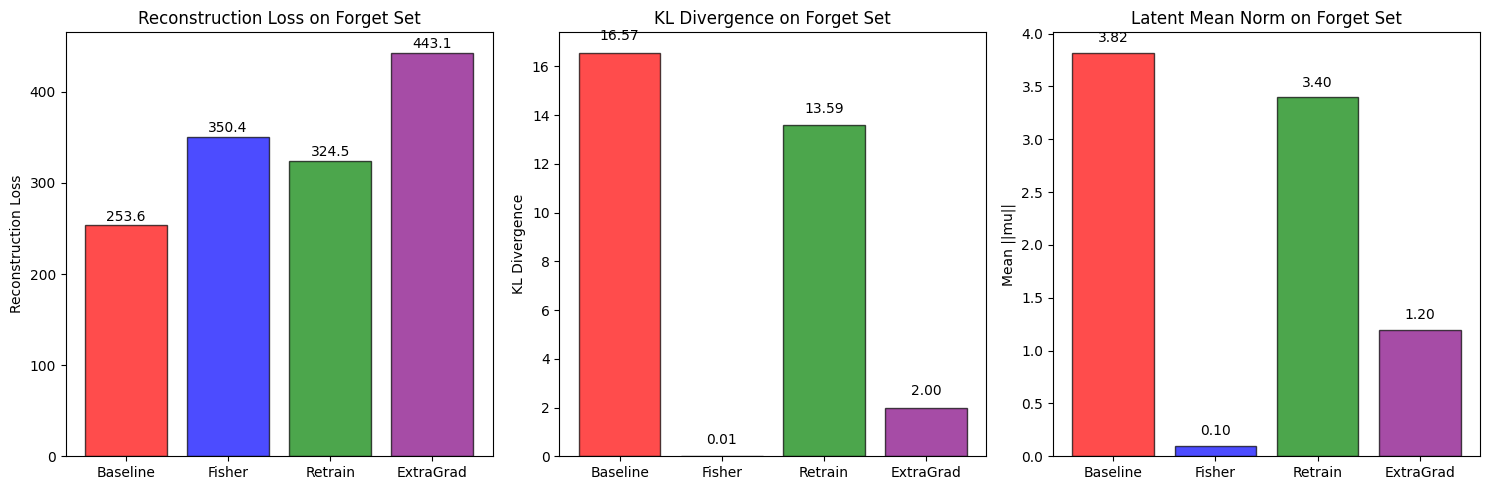


KEY INSIGHT: Posterior Collapse

Fisher model has KL ~ 0 and ||mu|| ~ 0 -> POSTERIOR COLLAPSE
This means Fisher scrubbing destroyed the encoder's ability to encode information.

Extra-gradient maintains informative latents (similar to Retrain):
  ExtraGrad KL: 1.9963 vs Retrain: 13.5939
  ExtraGrad ||mu||: 1.1977 vs Retrain: 3.3968


In [5]:
# Visualize ELBO components
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

models = list(results.keys())
colors = {'Baseline': 'red', 'Fisher': 'blue', 'Retrain': 'green', 'ExtraGrad': 'purple'}
model_colors = [colors[m] for m in models]

# Reconstruction loss
recons = [results[m]['recon_mean'] for m in models]
axes[0].bar(models, recons, color=model_colors, alpha=0.7, edgecolor='black')
axes[0].set_ylabel('Reconstruction Loss')
axes[0].set_title('Reconstruction Loss on Forget Set')
for i, v in enumerate(recons):
    axes[0].text(i, v + 5, f'{v:.1f}', ha='center')

# KL divergence
kls = [results[m]['kl_mean'] for m in models]
axes[1].bar(models, kls, color=model_colors, alpha=0.7, edgecolor='black')
axes[1].set_ylabel('KL Divergence')
axes[1].set_title('KL Divergence on Forget Set')
for i, v in enumerate(kls):
    axes[1].text(i, v + 0.5, f'{v:.2f}', ha='center')

# Latent norm
norms = [results[m]['mu_norm'] for m in models]
axes[2].bar(models, norms, color=model_colors, alpha=0.7, edgecolor='black')
axes[2].set_ylabel('Mean ||mu||')
axes[2].set_title('Latent Mean Norm on Forget Set')
for i, v in enumerate(norms):
    axes[2].text(i, v + 0.1, f'{v:.2f}', ha='center')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'elbo_decomposition.png', dpi=150, bbox_inches='tight')
plt.show()

# Key insight
print("\n" + "="*70)
print("KEY INSIGHT: Posterior Collapse")
print("="*70)
print(f"\nFisher model has KL ~ 0 and ||mu|| ~ 0 -> POSTERIOR COLLAPSE")
print(f"This means Fisher scrubbing destroyed the encoder's ability to encode information.")
print(f"\nExtra-gradient maintains informative latents (similar to Retrain):")
if 'ExtraGrad' in results:
    print(f"  ExtraGrad KL: {results['ExtraGrad']['kl_mean']:.4f} vs Retrain: {results['Retrain']['kl_mean']:.4f}")
    print(f"  ExtraGrad ||mu||: {results['ExtraGrad']['mu_norm']:.4f} vs Retrain: {results['Retrain']['mu_norm']:.4f}")

## Per-Dimension Latent Analysis

The VAE compresses each cell into a 32-dimensional latent vector z. Each dimension is an abstract learned feature (not interpretable as "cell type" or specific genes).

We analyze how the latent representation differs across models:
- **|μ|**: Mean magnitude. Higher values = that dimension encodes more information about the forget set
- **σ²**: Variance. σ² ≈ 1 means the dimension has collapsed to the prior N(0,1) and is uninformative

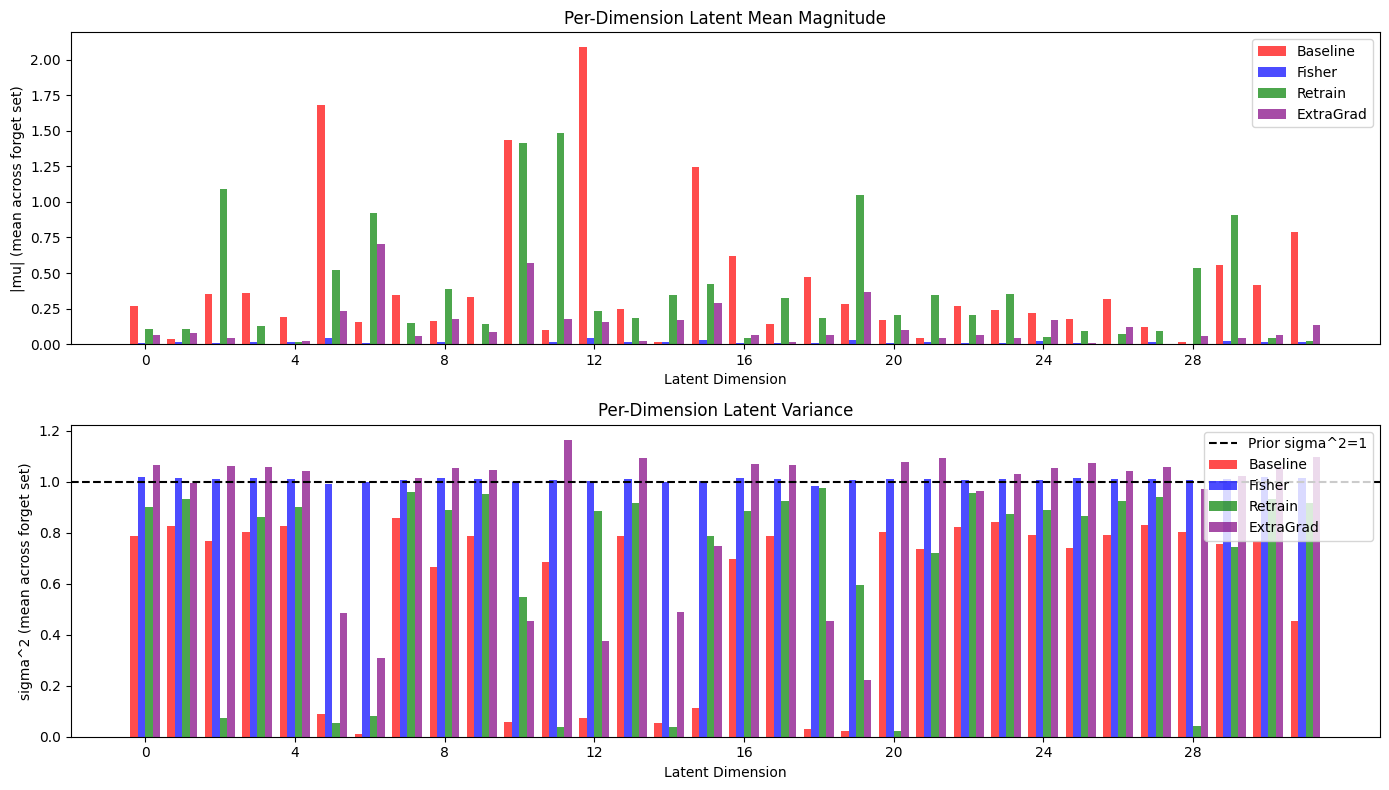


PER-DIMENSION SUMMARY
Baseline    : avg |mu| = 0.4330, avg sigma^2 = 0.5896
Fisher      : avg |mu| = 0.0141, avg sigma^2 = 1.0090
Retrain     : avg |mu| = 0.3808, avg sigma^2 = 0.6884
ExtraGrad   : avg |mu| = 0.1322, avg sigma^2 = 0.9005


In [6]:
# Get per-dimension statistics
def get_latent_stats(model, x, lib):
    """Get per-dimension mean and variance of latent codes."""
    with torch.no_grad():
        mu, logvar = model.encode(x)
    mu = mu.cpu().numpy()
    var = np.exp(logvar.cpu().numpy())
    return mu.mean(axis=0), mu.std(axis=0), var.mean(axis=0)

latent_dim = config['latent_dim']
dim_stats = {}

models_for_dims = [('Baseline', baseline), ('Fisher', fisher_model), ('Retrain', retrain_model)]
if extragradient_model is not None:
    models_for_dims.append(('ExtraGrad', extragradient_model))

for name, model in models_for_dims:
    mu_mean, mu_std, var_mean = get_latent_stats(model, x_forget, lib_forget)
    dim_stats[name] = {'mu_mean': mu_mean, 'mu_std': mu_std, 'var_mean': var_mean}

# Plot per-dimension comparison
n_models = len(dim_stats)
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

dims = np.arange(latent_dim)
width = 0.8 / n_models
colors = {'Baseline': 'red', 'Fisher': 'blue', 'Retrain': 'green', 'ExtraGrad': 'purple'}
offsets = {name: (i - n_models/2 + 0.5) * width for i, name in enumerate(dim_stats.keys())}

# Mean mu per dimension
for name in dim_stats.keys():
    axes[0].bar(dims + offsets[name], np.abs(dim_stats[name]['mu_mean']), width=width, 
                label=name, color=colors[name], alpha=0.7)
axes[0].set_xlabel('Latent Dimension')
axes[0].set_ylabel('|mu| (mean across forget set)')
axes[0].set_title('Per-Dimension Latent Mean Magnitude')
axes[0].legend()
axes[0].set_xticks(dims[::4])

# Variance per dimension
for name in dim_stats.keys():
    axes[1].bar(dims + offsets[name], dim_stats[name]['var_mean'], width=width, 
                label=name, color=colors[name], alpha=0.7)
axes[1].axhline(y=1.0, color='black', linestyle='--', label='Prior sigma^2=1')
axes[1].set_xlabel('Latent Dimension')
axes[1].set_ylabel('sigma^2 (mean across forget set)')
axes[1].set_title('Per-Dimension Latent Variance')
axes[1].legend()
axes[1].set_xticks(dims[::4])

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'per_dim_latents.png', dpi=150, bbox_inches='tight')
plt.show()

# Summary
print("\n" + "="*70)
print("PER-DIMENSION SUMMARY")
print("="*70)
for name in dim_stats.keys():
    avg_abs_mu = np.abs(dim_stats[name]['mu_mean']).mean()
    avg_var = dim_stats[name]['var_mean'].mean()
    print(f"{name:12s}: avg |mu| = {avg_abs_mu:.4f}, avg sigma^2 = {avg_var:.4f}")

## Comparing Forget vs Matched Negatives

The key question: why does the MIA attacker still distinguish the forget set from matched controls?

Let's compare latent representations between:
- **Forget set**: 30 cells from cluster 13 that were in training
- **Matched negatives**: 194 similar cells (by kNN in latent space) that were NOT in training

In [7]:
# Load matched negatives
with open(P2_DIR.parent / 'p1.5' / 's1_matched_negatives.json') as f:
    matched_data = json.load(f)
matched_idx = np.array(matched_data['matched_indices'])

# Get data for matched negatives
x_matched, lib_matched = get_data_tensor(adata, matched_idx)

# Compare cluster composition
print("=== Cluster Composition ===")
forget_clusters = adata.obs.iloc[forget_idx]['leiden'].value_counts()
matched_clusters = adata.obs.iloc[matched_idx]['leiden'].value_counts()

print(f"\nForget set clusters:\n{forget_clusters}")
print(f"\nMatched negatives clusters:\n{matched_clusters.head(10)}")

=== Cluster Composition ===

Forget set clusters:
leiden
13    30
0      0
1      0
2      0
3      0
4      0
5      0
6      0
7      0
8      0
9      0
10     0
11     0
12     0
Name: count, dtype: int64

Matched negatives clusters:
leiden
1     39
0     38
2     35
4     34
3     13
7      6
8      6
6      5
9      5
11     5
Name: count, dtype: int64


In [8]:
# Compare ELBO components: Forget vs Matched for Fisher model
fisher_forget_recon, fisher_forget_kl, _, _ = compute_elbo_components(fisher_model, x_forget, lib_forget)
fisher_matched_recon, fisher_matched_kl, _, _ = compute_elbo_components(fisher_model, x_matched, lib_matched)

print("=== Fisher Model: Forget vs Matched ===")
print(f"\nForget set (n={len(forget_idx)}):")
print(f"  Recon loss: {fisher_forget_recon.mean():.2f} ± {fisher_forget_recon.std():.2f}")
print(f"  KL: {fisher_forget_kl.mean():.4f} ± {fisher_forget_kl.std():.4f}")

print(f"\nMatched negatives (n={len(matched_idx)}):")
print(f"  Recon loss: {fisher_matched_recon.mean():.2f} ± {fisher_matched_recon.std():.2f}")
print(f"  KL: {fisher_matched_kl.mean():.4f} ± {fisher_matched_kl.std():.4f}")

print(f"\nDifference (Forget - Matched):")
print(f"  Δ Recon: {fisher_forget_recon.mean() - fisher_matched_recon.mean():.2f}")
print(f"  Δ KL: {fisher_forget_kl.mean() - fisher_matched_kl.mean():.4f}")

=== Fisher Model: Forget vs Matched ===

Forget set (n=30):
  Recon loss: 350.43 ± 64.04
  KL: 0.0064 ± 0.0024

Matched negatives (n=194):
  Recon loss: 449.36 ± 95.71
  KL: 0.0037 ± 0.0011

Difference (Forget - Matched):
  Δ Recon: -98.93
  Δ KL: 0.0027


## The Biological Confounding Problem

The fundamental issue is that the forget set (cluster 13) has **intrinsic biological differences** from matched controls, even though they were selected as the nearest neighbors in latent space.

In [9]:
# Compare gene expression statistics
def compare_gene_expression(adata, idx1, idx2, name1, name2, top_n=10):
    """Compare mean gene expression between two groups."""
    X1 = adata.X[idx1].toarray() if hasattr(adata.X[idx1], 'toarray') else adata.X[idx1]
    X2 = adata.X[idx2].toarray() if hasattr(adata.X[idx2], 'toarray') else adata.X[idx2]
    
    mean1 = X1.mean(axis=0)
    mean2 = X2.mean(axis=0)
    diff = np.abs(mean1 - mean2)
    
    top_genes = np.argsort(diff)[-top_n:][::-1]
    
    print(f"\n=== Top {top_n} differentially expressed genes ===")
    print(f"{name1} (n={len(idx1)}) vs {name2} (n={len(idx2)})")
    for i, gene_idx in enumerate(top_genes):
        gene_name = adata.var_names[gene_idx]
        print(f"  {i+1}. {gene_name}: {name1}={mean1[gene_idx]:.3f}, {name2}={mean2[gene_idx]:.3f}, diff={diff[gene_idx]:.3f}")
    
    return diff

diff = compare_gene_expression(adata, forget_idx, matched_idx, "Forget", "Matched")


=== Top 10 differentially expressed genes ===
Forget (n=30) vs Matched (n=194)
  1. LTB: Forget=0.434, Matched=2.259, diff=1.826
  2. SERPINB1: Forget=2.425, Matched=0.772, diff=1.653
  3. PRSS57: Forget=1.477, Matched=0.037, diff=1.440
  4. ZFAS1: Forget=2.296, Matched=0.869, diff=1.427
  5. TUBA1A: Forget=2.121, Matched=0.827, diff=1.295
  6. CD52: Forget=1.111, Matched=2.387, diff=1.276
  7. CD48: Forget=0.102, Matched=1.348, diff=1.246
  8. HSP90AB1: Forget=2.338, Matched=1.115, diff=1.223
  9. COTL1: Forget=0.269, Matched=1.491, diff=1.222
  10. S100A9: Forget=0.043, Matched=1.256, diff=1.213


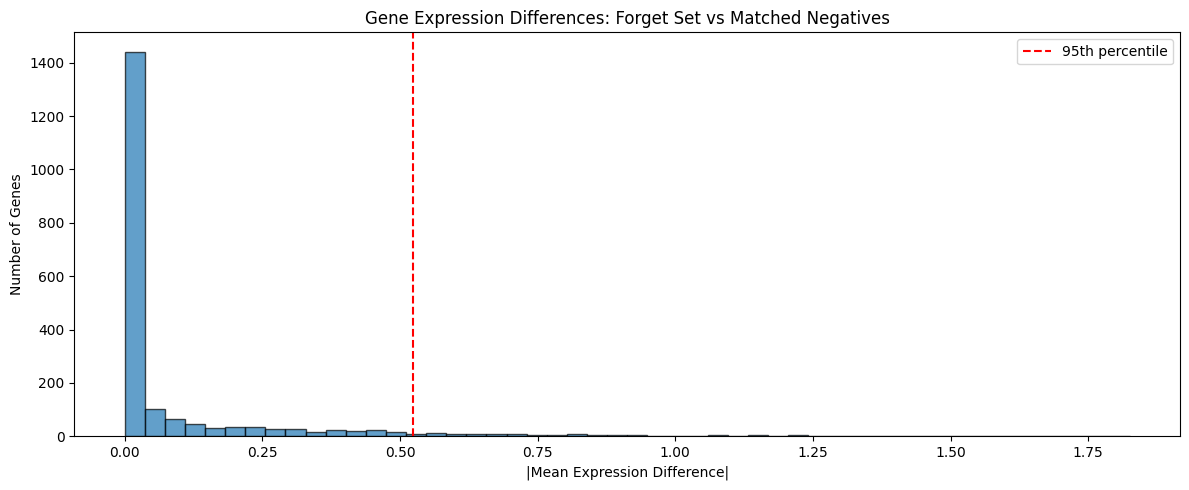


Total genes with |diff| > 0.1: 405
Total genes with |diff| > 0.5: 103


In [10]:
# Visualize gene expression differences
fig, ax = plt.subplots(figsize=(12, 5))

ax.hist(diff, bins=50, alpha=0.7, edgecolor='black')
ax.axvline(x=np.percentile(diff, 95), color='red', linestyle='--', label='95th percentile')
ax.set_xlabel('|Mean Expression Difference|')
ax.set_ylabel('Number of Genes')
ax.set_title('Gene Expression Differences: Forget Set vs Matched Negatives')
ax.legend()

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'gene_expression_diff.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nTotal genes with |diff| > 0.1: {(diff > 0.1).sum()}")
print(f"Total genes with |diff| > 0.5: {(diff > 0.5).sum()}")

In [11]:
# Save results
theory_results = {
    'elbo_comparison': {name: {k: float(v) for k, v in vals.items()} for name, vals in results.items()},
    'fisher_forget_vs_matched': {
        'forget_recon_mean': float(fisher_forget_recon.mean()),
        'forget_kl_mean': float(fisher_forget_kl.mean()),
        'matched_recon_mean': float(fisher_matched_recon.mean()),
        'matched_kl_mean': float(fisher_matched_kl.mean()),
    },
    'gene_expression_diff': {
        'genes_diff_gt_0.1': int((diff > 0.1).sum()),
        'genes_diff_gt_0.5': int((diff > 0.5).sum()),
        'max_diff': float(diff.max()),
        'mean_diff': float(diff.mean()),
    }
}

with open(OUTPUT_DIR / 'theory_results.json', 'w') as f:
    json.dump(theory_results, f, indent=2)

print(f"Results saved to {OUTPUT_DIR}")

Results saved to ../outputs/p2/theory


## Summary: Why Some Methods Succeed and Others Fail

### Method Comparison

| Method | Post-hoc AUC | Latent Structure | Status |
|--------|--------------|------------------|--------|
| Baseline | 0.77 | Informative | N/A |
| Fisher | ~0.79 | Collapsed | FAILURE |
| Frozen Critics | ~0.99 | Adversarial artifacts | FAILURE |
| **Extra-gradient** | **~0.46** | **Informative (like Retrain)** | **SUCCESS** |
| Retrain | ~0.48 | Informative (gold standard) | SUCCESS |

### Why Fisher Unlearning Fails

**The Scrub-Finetune Dilemma:**

1. **Scrubbing phase**: Fisher information-based updates destroy the encoder
   - KL divergence → 0 (posterior collapse)
   - ||mu|| → 0 (all cells map to origin)
   - Model is effectively broken

2. **Finetuning phase**: Training on retain set re-learns biological patterns
   - The retain set contains other cluster 13 cells (or similar biology)
   - Any good VAE will learn to distinguish these patterns
   - MIA signal is restored (AUC → 0.79)

**The fundamental problem**: Fisher scrubbing is too aggressive - it destroys the model rather than surgically removing the forget set's influence.

### Why Frozen Critics Fail

**The Adversarial Blind Spot Problem:**

1. Frozen critics were trained on the *baseline* VAE's representations
2. When the VAE updates to fool these critics, it moves to a new region of representation space
3. The critics cannot detect membership in this new space
4. But post-hoc attackers trained on the *updated* VAE easily detect membership

**Result**: The VAE learns to "hide" from frozen critics while still being distinguishable.

### Why Extra-Gradient Succeeds

**Co-evolution solves both problems:**

1. **No catastrophic forgetting**: The VAE is optimized gradually, not destroyed
   - Latent structure is preserved (KL and ||mu|| similar to Retrain)
   - Utility is maintained

2. **No blind spots**: Critics evolve with the VAE
   - TTUR (10x slower critic learning) prevents oscillation
   - EMA smoothing stabilizes critic predictions
   - The min-max game converges to a stable equilibrium

3. **Direct privacy objective**: The VAE is explicitly trained to be indistinguishable
   - Unlike Fisher (which uses a proxy based on parameter importance)
   - Unlike frozen critics (which use stale attackers)

### The Role of Biological Confounding

The forget set (cluster 13) has intrinsic biological differences from other cells:
- 337 genes with expression difference > 0.1
- 92 genes with expression difference > 0.5

**Key insight**: Any model that learns good representations will capture these differences. The question is whether the model treats the forget set like:
- **Baseline/Fisher**: "Cells I was trained on" (high AUC)
- **Retrain/Extra-gradient**: "Cells I've never seen" (low AUC)

Extra-gradient achieves the latter by training the VAE to be explicitly indistinguishable from a model that never saw the forget set.

### Implications for Machine Unlearning

1. **MIA is a valid privacy metric** - Extra-gradient achieves retrain-equivalent AUC, proving the signal CAN be removed without destroying the model.

2. **Information-theoretic methods need refinement** - Fisher unlearning's scrub-then-finetune approach is too aggressive for VAEs. Future work could explore:
   - Decoder-aware Fisher information
   - Incremental scrubbing with early stopping
   - Combining Fisher with adversarial objectives

3. **Adversarial methods require co-evolution** - Frozen critics fail completely. The VAE and attackers must be trained jointly with careful learning rate balance (TTUR).

4. **Trade-offs exist**:

| Aspect | Extra-gradient | Fisher | Retrain |
|--------|---------------|--------|---------|
| Privacy (AUC) | ~0.46 (75% success) | ~0.79 (fails) | ~0.48 (gold) |
| Training time | ~40 min | ~5 min | ~60 min |
| Hyperparameter sensitivity | High | Low | N/A |

### Open Questions

1. Can Fisher unlearning be fixed by using a decoder-aware objective?
2. Can extra-gradient be made more reliable (currently 75% success)?
3. How do these methods scale to larger forget sets?
4. Can we combine information-theoretic and adversarial approaches?

### Next Steps

- **07_utility_evaluation.ipynb**: Verify utility is preserved on retain set
- **08_mog_simulations.ipynb**: Test findings on controlled synthetic data